<a href="https://colab.research.google.com/github/jbarsce/AprendizajePorRefuerzos/blob/master/lab_1_intro_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 1: Introducción al aprendizaje por refuerzos

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2023

## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos, los cuáles son necesarios para realizar este Lab.

### Repaso rápido



* Recompensa: señal $r$ recibida desde el entorno que recompensa o castiga el agente según su desempeño con respecto al objetivo de la tarea.

* Valor: función $v_\pi (s)$ que establece cuánto el agente espera percibir de recompensa al seguir la política $\pi$ partiendo desde el estado $s$. También se la suele expresar como $Q_\pi(s,a)$, indicando cuánto el agente espera percibir siguiendo la política $\pi$ partiendo desde el estado $s$ y siguiendo la acción $a$.

* Política: función $\pi(s) \to a$ que mapea un estado a una acción. Se suele expresar como probabilidad de elegir la acción $\pi(a \mid s)$. La política $\epsilon$-greedy, en donde $\epsilon$ es la probabilidad de exploración (normalmente menor que la probabilidad de explotación) está dada por $\pi(a \mid s) = 1 - \epsilon$ si $a$ es la mejor acción, caso contrario pasa a estar dada por $\pi(a \mid s) = \epsilon$.

Por otra parte, en la política Softmax, no se busca la acción con máxima probabilidad sino que se computa la probabilidad de cada una mediante la función Softmax y se realiza un sorteo entre ellas pesado por la misma. Así, para cada acción $a$, $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

En este notebook vemos dos algoritmos para actualizar la función de valor (y, por lo tanto, la política de selección de acciones):

* Actualización por SARSA (on-policy).

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo SARSA](https://github.com/DiploDatos/AprendizajePorRefuerzos/blob/master/images/sarsa.png?raw=1)


* Actualización por Q-Learning (off-policy)

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma \arg\max_{a'} Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo Q-Learning](https://github.com/DiploDatos/AprendizajePorRefuerzos/blob/master/images/q_learning.png?raw=1)

Fuente de las imágenes: capítulo 6 de [Reinforcement Learning: An Introduction](http://www.incompleteideas.net/book/the-book.html).

## Librería a usar: Librería OpenAI Gym

[OpenAI Gym](https://gym.openai.com/) (Brockman et. al., 2016) es una librería de OpenAI que ofrece entornos y una interfaz estándar con la cuál probar nuestros agentes. Su objetivo es proveer benchmarks unificados para ver el desempeño de algoritmos en el entorno y así poder saber con facilidad cómo es su desempeño comparado con los demás. Parte de la siguiente sección está basada en la [documentación oficial de OpenAI](https://gym.openai.com/docs/).

La interfaz principal de los ambientes de gym es la interfaz Env. La misma posee cinco métodos principales:

* ```reset(self, seed)``` : Reinicia el estado del entorno, a su estado inicial, devolviendo una observación de dicho estado. Opcionalmente, establece la semilla aleatoria del generador de números aleatorios del presente entorno.

* ```step(self, action)``` : "Avanza" un timestep del ambiente. Devuelve: ```observation, reward, terminated, truncated, info```.

* ```render(self)``` : Muestra en pantalla una parte del ambiente.

* ```close(self)``` : Finaliza con la instancia del agente.


Por otra parte, cada entorno posee los siguientes tres atributos principales:

* ```action_space``` : El objeto de tipo Space correspondiente al espacio de acciones válidas.

* ```observation_space``` : El objeto de tipo Space correspondiente a todos los rangos posibles de observaciones.

* ```reward_range``` : Tupla que contiene los valores mínimo y máximo de recompensa posible.

Algunas de las ejecuciones contienen videos. Para poder verlos se necesita previamente instalar la librería ffmpeg; para instalarla desde Linux ejecutar en consola

```apt-get install ffmpeg```

desde Mac, reemplazar *apt-get* por *brew*

desde Windows, descargarla desde

[https://ffmpeg.org/download.html](https://ffmpeg.org/download.html)

(Nota: las animaciones son a modo ilustrativo, si no se desea instalar la librería se puede directamente eliminar la línea de código donde se llama al método ``env.render(mode='human')``)

Código básico de importación y funciones de graficación (no modificar)

In [1]:
# @title Código básico importacion y utilerías (no modificar)

import itertools
from typing import Any, Callable, Tuple

import numpy as np
import matplotlib.pyplot as plt


def plot_reward_per_episode(reward_ep) -> None:
    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(
        1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [
        acumulated_rewards[i] / episode_number[i]
        for i in range(len(acumulated_rewards))
    ]

    plt.plot(reward_per_episode)
    plt.title("Recompensa acumulada por episodio")
    plt.show()


def plot_steps_per_episode(timesteps_ep) -> None:
    # se muestra la curva de aprendizaje de los pasos por episodio
    episode_steps = np.array(timesteps_ep)
    plt.plot(np.array(range(0, len(episode_steps))), episode_steps)
    plt.title("Pasos (timesteps) por episodio")
    plt.show()


def plot_steps_per_episode_smooth(timesteps_ep) -> None:
    episode_steps = np.array(timesteps_ep)

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(
        1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [
        acumulated_steps[i] / episode_number[i] for i in range(
            len(acumulated_steps))
    ]

    plt.plot(steps_per_episode)
    plt.title("Pasos (timesteps) acumulados por episodio")
    plt.show()


def draw_value_matrix(q) -> None:
    n_rows = 4
    n_columns = 12
    n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):
            state_values = []

            for action in range(n_actions):
                state_values.append(
                    q.get((row * n_columns + column, action), -100))

            maximum_value = max(
                state_values
            )  # determinamos la acción que arroja máximo valor

            q_value_matrix[row, column] = maximum_value

    # el valor del estado objetivo se asigna en -1 (reward recibido al llegar)
    # para que se coloree de forma apropiada
    q_value_matrix[3, 11] = -1

    # se grafica la matriz de valor
    plt.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    plt.tight_layout()
    plt.colorbar()

    for row, column in itertools.product(
        range(q_value_matrix.shape[0]), range(q_value_matrix.shape[1])
    ):
        left_action = q.get((row * n_columns + column, 3), -1000)
        down_action = q.get((row * n_columns + column, 2), -1000)
        right_action = q.get((row * n_columns + column, 1), -1000)
        up_action = q.get((row * n_columns + column, 0), -1000)

        arrow_direction = "D"
        best_action = down_action

        if best_action < right_action:
            arrow_direction = "R"
            best_action = right_action
        if best_action < left_action:
            arrow_direction = "L"
            best_action = left_action
        if best_action < up_action:
            arrow_direction = "U"
            best_action = up_action
        if best_action == -1:
            arrow_direction = ""

        # notar que column, row están invertidos en orden en la línea de abajo
        # porque representan a x,y del plot
        plt.text(column, row, arrow_direction, horizontalalignment="center")

    plt.xticks([])
    plt.yticks([])
    plt.show()

    print("\n Matriz de mejor acción-valor (en números): \n\n", q_value_matrix)

Ejemplo: agente CartPole

In [2]:
from IPython.display import clear_output

try:
  import google.colab
  IN_COLAB = True

  !pip install gymnasium

except:
  IN_COLAB = False

import gymnasium as gym

# no es posible mostrar videos de ejecución del agente desde Colab
if not IN_COLAB:

    env = gym.make('CartPole-v0')
    env.reset()
    env.render()

    for _ in range(500):
        env.render()
        # se ejecuta una acción aleatoria
        obs, reward, terminated, truncated, info = env.step(
           env.action_space.sample())

        done = terminated or truncated
        if done:
            env.reset()
    env.close()
    clear_output()

Ejemplo: agente Mountain Car

In [3]:
if not IN_COLAB:
    env = gym.make('MountainCar-v0')
    obs = env.reset()
    for t in range(500):
        env.render()
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    env.close()
    clear_output()

## Ejemplo 1: The Cliff.


![](https://github.com/GIDISIA/RLDiplodatos/blob/master/images/cliffwalking.png?raw=1)

donde S= starting point, G= goal

(imagen de Sutton y Barto, 2018)

Descripción del entorno:

Acciones:

* $\uparrow$ - Arriba
* $\downarrow$ - Abajo
* $\rightarrow$ - Derecha
* $\leftarrow$ - Izquierda

Función de recompensa:

* $-1$ en todos los demás estados
* $-100$ en el acantilado

Nota: caer en el acantilado devuelve al agente al estado inicial en un mismo episodio

Vemos los bloques básicos de nuestro agente

Definimos el método de elección de acciones. En este caso el mismo utiliza la política de exploración $\epsilon$-greedy.

In [4]:
def choose_action_e_greedy(
        state: int,
        actions: range,
        q: dict,
        hyperparameters: dict,
        random_state: np.random.RandomState,
) -> int:
    """
    Elije una acción de acuerdo al aprendizaje realizado previamente
    usando una política de exploración épsilon-greedy
    """
    # ej: para 4 acciones inicializa en [0,0,0,0]
    q_values = [q.get((state, a), 0.0) for a in actions]
    max_q = max(q_values)
    # sorteamos un número: es menor a épsilon?
    if random_state.uniform() < hyperparameters['epsilon']:
        # sí: se selecciona una acción aleatoria
        return random_state.choice(actions)

    count = q_values.count(max_q)

    # hay más de un máximo valor de estado-acción?
    if count > 1:
        # sí: seleccionamos uno de ellos aleatoriamente
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        # no: seleccionamos el máximo valor de estado-acción
        i = q_values.index(max_q)

    return actions[i]

In [5]:
def choose_action_softmax() -> int:
    """
    Elije una acción de acuerdo al aprendizaje realizado previamente
    usando una política softmax
    """

    # TODO: implementar
    pass

Definimos el esqueleto del método learn, el cuál toma una transición y cambia el dict de los valores de Q de acuerdo a algún algoritmo.

In [6]:
def learn_SARSA(
        state: int,
        action: range,
        reward: float,
        next_state: int,
        next_action: range,
        hyperparameters: Dict[str, Any],
        q: Dict[Tuple, float],
) -> None:
    """
    Realiza una actualización según el algoritmo SARSA, para una transición
    de estado dada
    Args:
        state: El estado actual (tipo de datos depende del contexto).
        action: La acción tomada en el estado actual (tipo de datos depende del contexto).
        reward: La recompensa obtenida tras tomar la acción (número de punto flotante).
        next_state: El siguiente estado alcanzado tras tomar la acción (tipo de datos depende del contexto).
        next_action: La siguiente acción a tomar en el siguiente estado (tipo de datos depende del contexto).
        hyperparameters: Un diccionario que contiene los hiperparámetros para el algoritmo SARSA.
        q: Un diccionario que almacena los valores Q para cada par estado-acción (diccionario de tuplas a números de punto flotante).
    """
    q_back = q.get((state,action), 0.0)
    q_next = q.get((next_state, next_action),0.0)
    q[(state,action)] = q_back + hyperparameters.get("alpha") * ( reward + hyperparameters.get("gamma")  * q_next - q_back)

In [7]:
# completar argumentos de la función para hacer una actualización Q-learning
def learn_Q_learning(
        state: int, 
        action: range,
        reward: float,
        next_state: int,
        next_action: range,
        hyperparameters: Dict[str, Any],
        q: Dict[Tuple, float],
) -> None:
    """
    Realiza una actualización según el algoritmo Q-learning, para una transición
    de estado dada
    
    Args:
        state (Any): El estado actual.
        action (Any): La acción tomada en el estado actual.
        reward (Any): La recompensa obtenida tras tomar la acción.
        next_state (Any): El siguiente estado alcanzado tras tomar la acción.
        next_action (Any): La siguiente acción a tomar en el siguiente estado.
        hyperparameters (Dict[str, Any]): Un diccionario que contiene los hiperparámetros
            para el algoritmo Q-learning, incluyendo 'alpha' (tasa de aprendizaje),
            'gamma' (factor de descuento), y 'epsilon' (tasa de exploración).
        q (Dict[Tuple, Any]): Un diccionario que almacena los valores Q para cada par
            estado-acción.

    Returns:
        None
    """

    q_back = q.get((state,action), 0.0)

    q[(state,action)] = q_back + hyperparameters.get("alpha") * ( reward + ( max([q.get((next_state, a), 0.0) for a in
                             range(env.action_space.n)])) - q_back)

Finalmente, definimos el método principal de iteraciones.

In [8]:
def run(
    learning_function: Callable,
    hyperparameters: dict,
    episodes_to_run: int,
    env: gym.Env,
    actions: range,
    q: dict,
    random_state: np.random.RandomState,
) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Corre el algoritmo de RL para el ambiente FrozenLake-v0.
    Args:
        learning_function: función de actualización de algoritmo de aprendizaje
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        episodes_to_run: cantidad de episodios a ejecutar
        env: ambiente de Gymnasium
        actions: lista de acciones posibles
        q: diccionario de valores de estado-acción
        random_state: generador de números aleatorios
    """
    # registro de la cantidad de pasos que le llevó en cada episodio
    # llegar a la salida
    timesteps_of_episode = []
    # cantidad de recompensa que recibió el agente en cada episodio
    reward_of_episode = []

    for _ in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo
        # llega a la salida o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state, _ = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # elige una acción basado en el estado actual.
        # Filtra el primer elemento de state, que es el estado en sí mismo
        action = choose_action_e_greedy(
            state, actions, q, hyperparameters, random_state)

        while not done:
            # el agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, terminated, truncated, _ = env.step(action)

            next_action = choose_action_e_greedy(
                next_state, actions, q, hyperparameters, random_state)

            episode_reward += reward
            learning_function(
                state,
                action,
                reward,
                next_state,
                next_action,
                hyperparameters,
                q
            )

            done = terminated or truncated

            # if the algorithm does not converge, it stops after 2000 timesteps
            if not done and t < 2000:
                state = next_state
                action = next_action
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(
                    reward_of_episode, max(episode_reward, -100)
                )

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

Definidos los métodos básicos, procedemos a instanciar a nuestro agente.

In [9]:
# se crea el diccionario que contendrá los valores de Q
# para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos
hyperparameters = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.1,
    "tau": 25,
}


learning_function = learn_SARSA
episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

Ya instanciado, ejecutamos nuestro agente

In [10]:
avg_steps_per_episode, timesteps_ep, reward_ep = run(
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    q,
    random_state
)

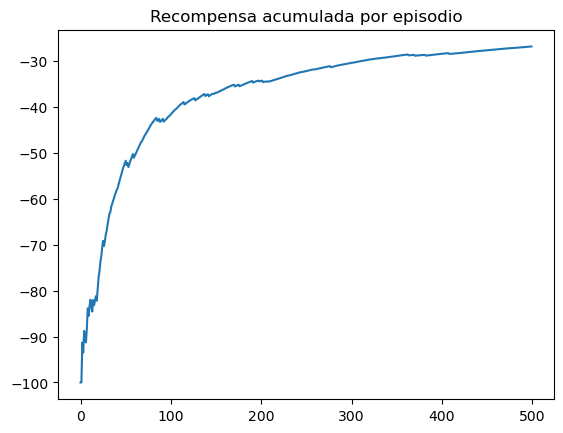

In [11]:
plot_reward_per_episode(reward_ep)

Veamos pasos por episodio

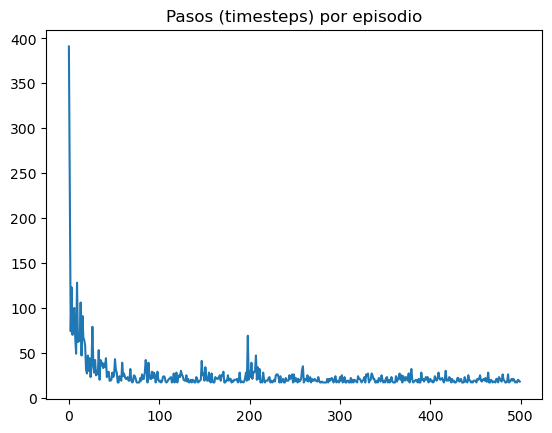

In [12]:
plot_steps_per_episode(timesteps_ep)

Suavizando...

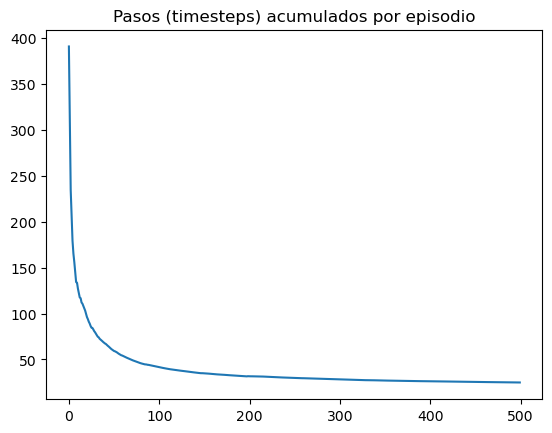

In [13]:
plot_steps_per_episode_smooth(timesteps_ep)

#### Análisis de matriz de acción-valor y política óptima

Siendo que este es un ejemplo tabular y de pocos estados / acciones, es posible realizar un análisis de convergencia desde otro punto de vista: desde el valor de la función $Q(s,a)$ para la mejor acción de cada estado, al finalizar el entrenamiento del agente, (sería la acción que el agente ejecutaría en cada estado bajo una política *greedy*). Ambos nos brindarán información sobre la convergencia alcanzada por el agente.

Tener en cuenta que este análisis se hace principalmente con fines educativos, para entornos más complejos el mismo puede no ser factible. En tales casos, un análisis alternativo podría consistir en hacer que el agente ejecute su política para la que fue entrenado, para hacer una evaluación a partir del comportamiento del mismo (esto último sería el *test de la política*, frente al *entrenamiento de la política* previo).

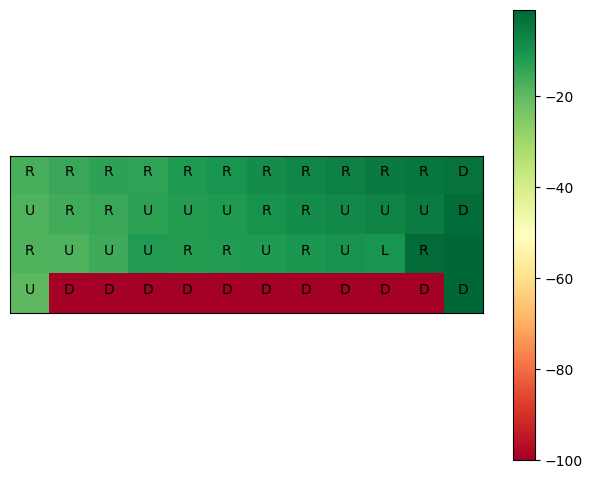


 Matriz de mejor acción-valor (en números): 

 [[ -17.23954428  -15.14316652  -13.47940719  -13.86734791  -11.50591433
   -10.42824021   -8.92910114   -7.36906975   -6.09772006   -5.02260286
    -4.246717     -3.48743802]
 [ -18.17688817  -16.29163152  -15.09887514  -13.57191616  -12.57200446
   -11.46204211  -10.28051994   -8.75636874   -8.02140089   -7.17268501
    -5.41325753   -2.24362335]
 [ -18.16818774  -17.96726471  -16.02741607  -12.12753358  -12.36502775
   -11.94064567  -11.56233996  -10.96253903   -9.96154144  -10.28531687
    -2.00258599   -1.        ]
 [ -19.72790699 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [14]:
draw_value_matrix(q)

In [15]:
env.close()

Q-Learning

Definidos los métodos básicos, procedemos a instanciar a nuestro agente.

In [16]:
# se crea el diccionario que contendrá los valores de Q
# para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos
hyperparameters = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.1,
    "tau": 25,
}


# se puede cambiar por learn_Q_learning, una vez que se implemente
learning_function = learn_Q_learning
episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

Ya instanciado, ejecutamos nuestro agente

In [17]:
avg_steps_per_episode, timesteps_ep, reward_ep = run(
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    q,
    random_state
)

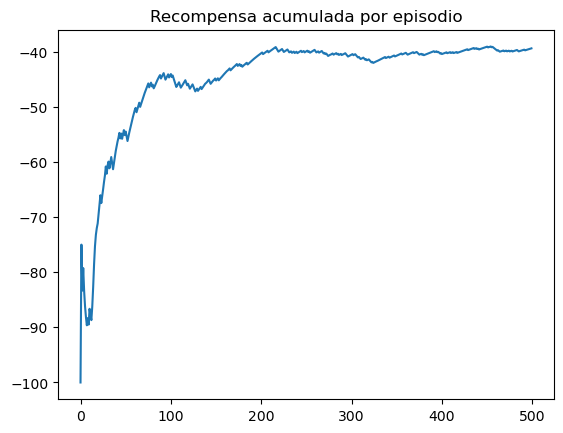

In [18]:
plot_reward_per_episode(reward_ep)

Veamos pasos por episodio

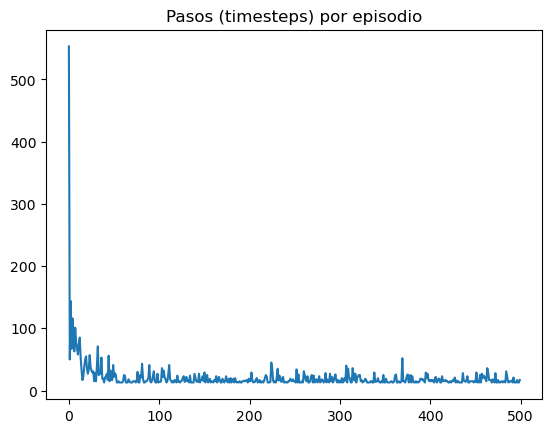

In [19]:
plot_steps_per_episode(timesteps_ep)

Suavizando...

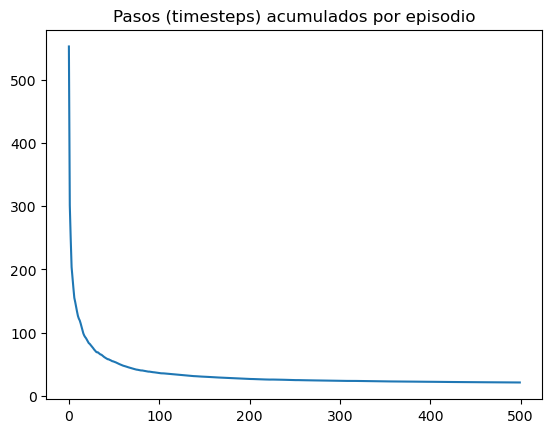

In [20]:
plot_steps_per_episode_smooth(timesteps_ep)

#### Análisis de matriz de acción-valor y política óptima

Siendo que este es un ejemplo tabular y de pocos estados / acciones, es posible realizar un análisis de convergencia desde otro punto de vista: desde el valor de la función $Q(s,a)$ para la mejor acción de cada estado, al finalizar el entrenamiento del agente, (sería la acción que el agente ejecutaría en cada estado bajo una política *greedy*). Ambos nos brindarán información sobre la convergencia alcanzada por el agente.

Tener en cuenta que este análisis se hace principalmente con fines educativos, para entornos más complejos el mismo puede no ser factible. En tales casos, un análisis alternativo podría consistir en hacer que el agente ejecute su política para la que fue entrenado, para hacer una evaluación a partir del comportamiento del mismo (esto último sería el *test de la política*, frente al *entrenamiento de la política* previo).

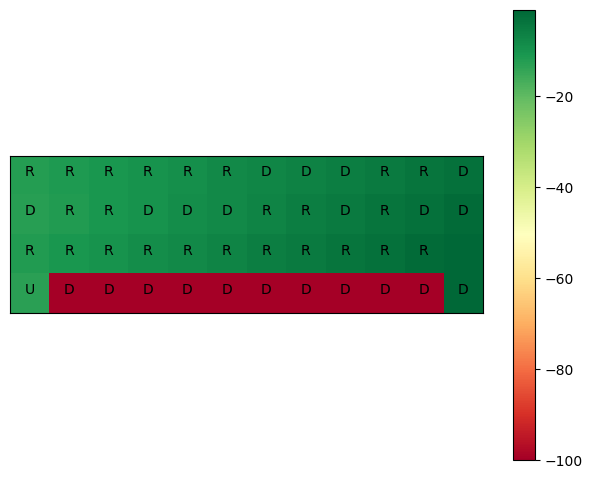


 Matriz de mejor acción-valor (en números): 

 [[ -12.3189387   -11.59140422  -10.84866451   -9.96310256   -9.18688713
    -8.34095048   -7.4542462    -6.72926453   -5.82792094   -4.91990551
    -3.95712468   -2.99947958]
 [ -12.87149892  -11.96404923  -10.98713428   -9.99742173   -8.99937844
    -7.99976186   -6.99991029   -5.99997592   -4.99999754   -3.99999928
    -2.99999988   -2.        ]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [21]:
draw_value_matrix(q)

In [22]:
env.close()

### 2 - Convergencia en Q-Learning vs. SARSA:
La implementación y ejecución del algoritmo Q-Learning en el entorno "The Cliff" muestra diferencias notables en términos de convergencia en comparación con SARSA. Estas diferencias se deben a la naturaleza "off-policy" de Q-Learning, que toma decisiones basadas en el valor máximo esperado de las recompensas futuras en lugar de seguir la política actual.

Q-Learning tiende a converger más rápido hacia una política óptima en "The Cliff" en comparación con SARSA. Esto significa que Q-Learning suele aprender una política que minimiza la penalización de caer en el acantilado de manera más eficiente que SARSA.
SARSA, al ser "on-policy," a menudo elige acciones más conservadoras y, en el proceso de aprendizaje, puede requerir más episodios para aprender a evitar el acantilado y converger hacia una política segura.
Razones para la Diferencia en Convergencia:

En Q-Learning, el agente no sigue su propia política actual para tomar decisiones, sino que elige la acción con el valor Q máximo. Esto le permite explorar más agresivamente y aprender más rápido, ya que no está limitado por las acciones determinadas por la política actual.
Por otro lado, en SARSA, el agente sigue su política actual para seleccionar acciones, lo que puede llevar a explorar menos agresivamente y, en algunos casos, mantener al agente en situaciones de alto riesgo como el acantilado.
En resumen, la diferencia en la convergencia entre Q-Learning y SARSA en el entorno "The Cliff" se debe a la mayor agresividad en la exploración de Q-Learning y a su capacidad para aprender de manera más eficiente al elegir acciones basadas en el valor máximo esperado. En este entorno específico, Q-Learning tiende a evitar el acantilado más rápidamente, lo que lo convierte en una opción preferida cuando la seguridad y la convergencia rápida son prioritarias.

### 3 -  Seteo de hiperparametros

Ejecutando con los siguientes parámetros: alpha=0.1, gamma=1, epsilon=0.1


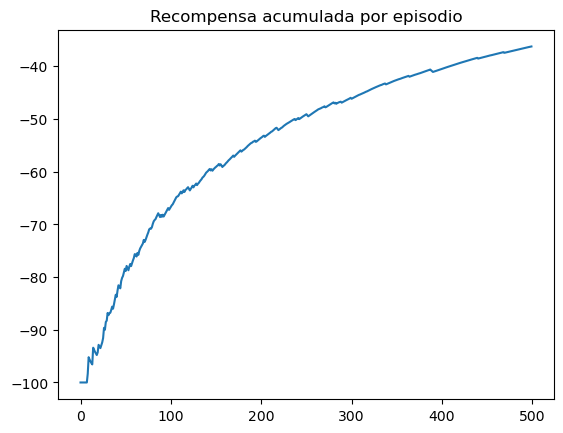

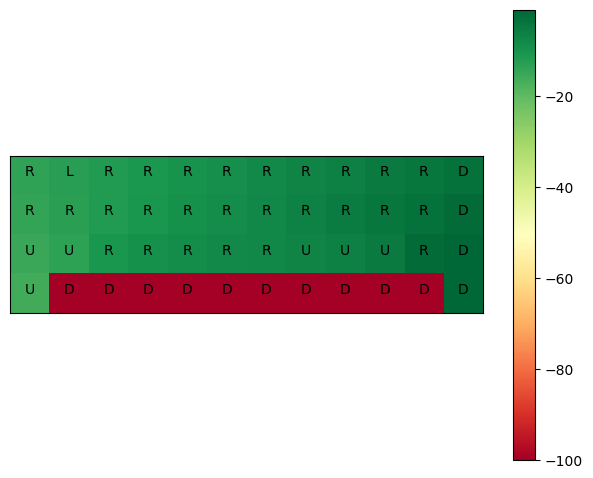


 Matriz de mejor acción-valor (en números): 

 [[ -13.80108519  -12.97736691  -12.02419512  -11.09938481  -10.12569898
    -9.14172525   -8.16414748   -7.16819995   -6.1565489    -5.16839092
    -4.20823696   -3.19673156]
 [ -14.18476404  -13.05544756  -11.89778642  -10.79239047   -9.78927953
    -8.74977696   -7.640636     -6.67479988   -5.44883936   -4.29095907
    -3.26264324   -2.08998087]
 [ -15.26632292  -13.61923814  -10.86878873   -9.58819336   -8.98765225
    -8.2846277    -7.65560026   -7.0637242    -6.15780515   -5.13291621
    -2.14565326   -1.        ]
 [ -16.31398686 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


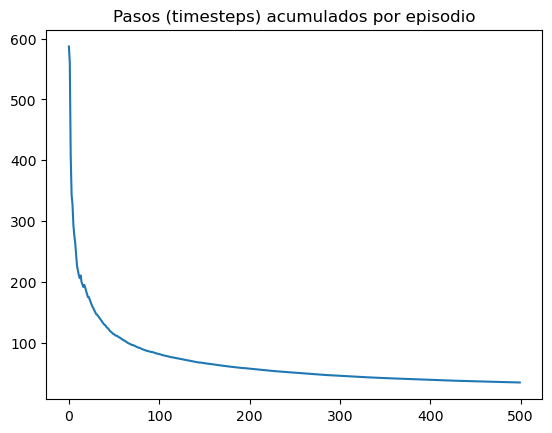

Ejecutando con los siguientes parámetros: alpha=0.1, gamma=1, epsilon=0.5


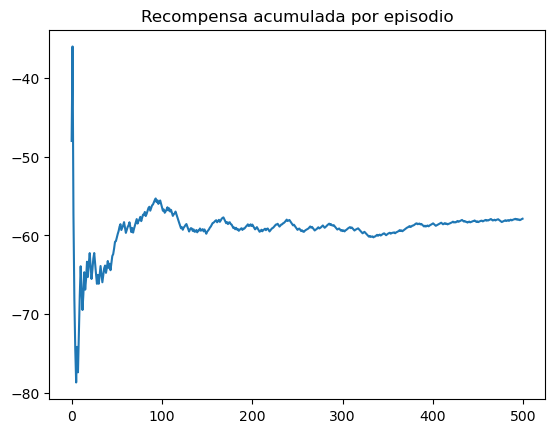

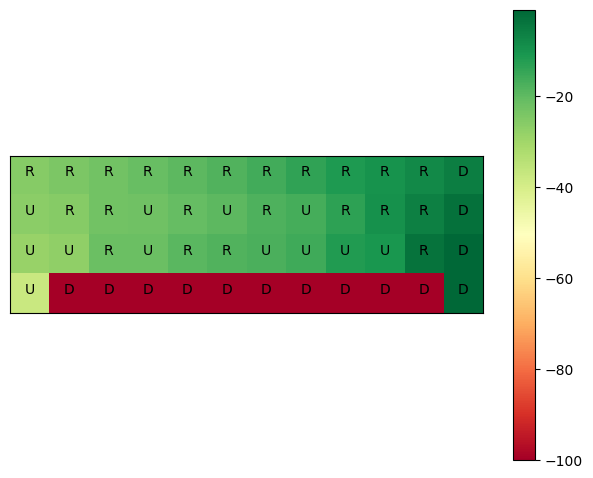


 Matriz de mejor acción-valor (en números): 

 [[ -25.89294717  -24.41924561  -23.03183642  -21.33874678  -19.71934034
   -18.21921816  -16.1645089   -14.14731278  -11.62932764  -10.1803146
    -8.2692066    -5.77327594]
 [ -26.90547085  -25.78211274  -22.69600727  -22.27562666  -20.87486609
   -19.63142736  -18.00466491  -16.83370104  -13.50468827   -9.51659788
    -6.25013418   -3.00774432]
 [ -28.52011464  -27.48007021  -21.72471885  -21.74768333  -19.39593782
   -18.28323767  -17.30197083  -15.91844281  -11.93296735  -10.76486994
    -3.5434071    -1.        ]
 [ -37.5731672  -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


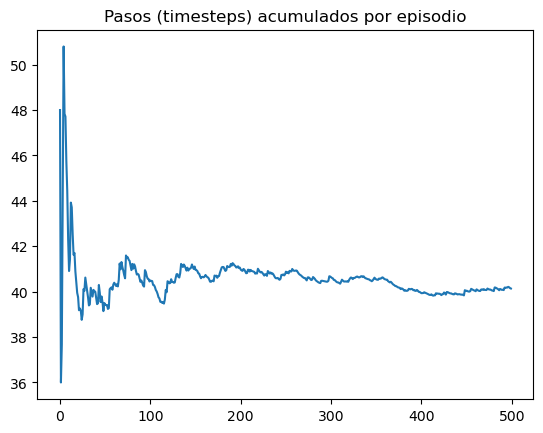

Ejecutando con los siguientes parámetros: alpha=0.1, gamma=1, epsilon=0.9


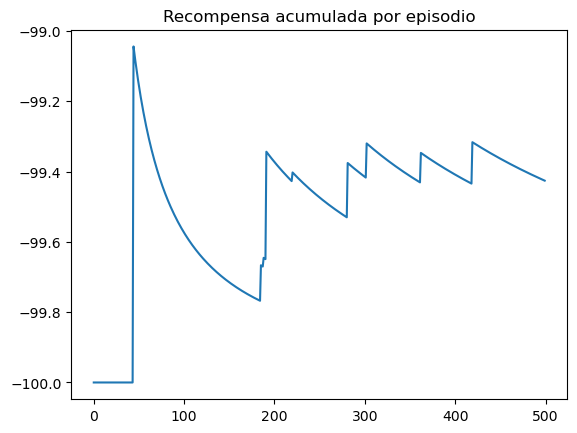

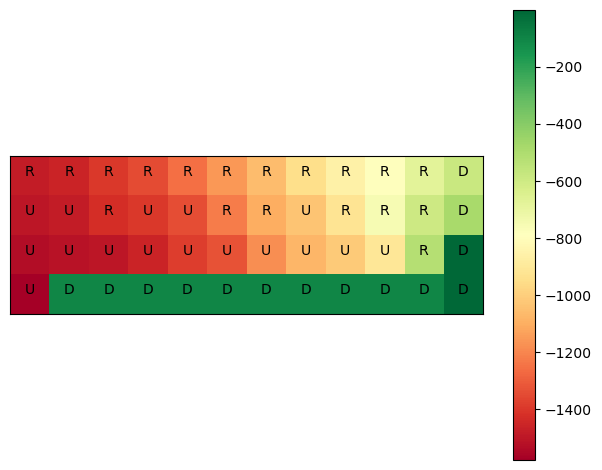


 Matriz de mejor acción-valor (en números): 

 [[-1.47911532e+03 -1.45603330e+03 -1.39638896e+03 -1.34804536e+03
  -1.25392399e+03 -1.15280933e+03 -1.05920321e+03 -9.46491619e+02
  -8.57750342e+02 -7.89036201e+02 -6.77430035e+02 -5.84267202e+02]
 [-1.49880771e+03 -1.48440383e+03 -1.42844822e+03 -1.39502637e+03
  -1.33981424e+03 -1.22416305e+03 -1.10145752e+03 -1.03476733e+03
  -9.20691236e+02 -7.55158788e+02 -5.93470880e+02 -4.82323643e+02]
 [-1.52973186e+03 -1.51039104e+03 -1.50237090e+03 -1.45441124e+03
  -1.38044742e+03 -1.32611918e+03 -1.17869792e+03 -1.07789223e+03
  -1.01185294e+03 -9.11353921e+02 -5.20141910e+02 -1.00000000e+00]
 [-1.57700801e+03 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
  -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
  -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+00]]


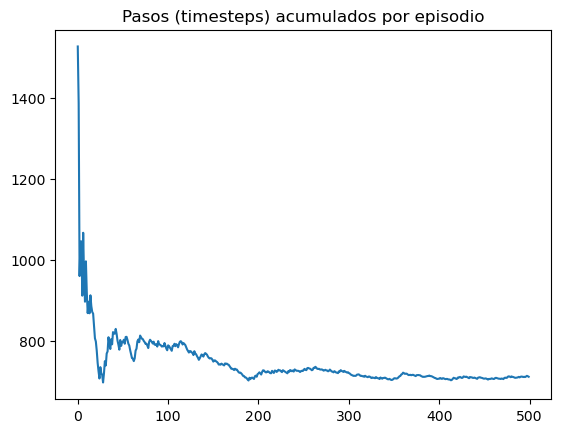

Ejecutando con los siguientes parámetros: alpha=0.1, gamma=100, epsilon=0.1


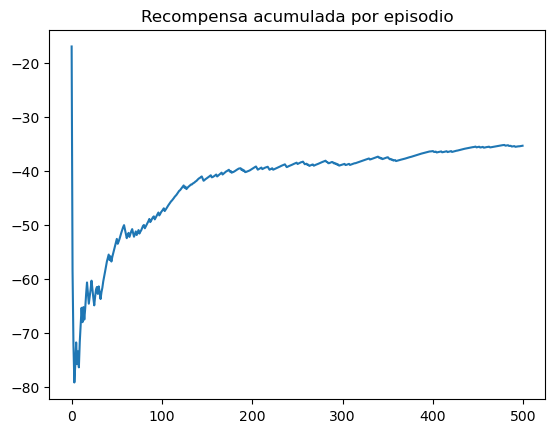

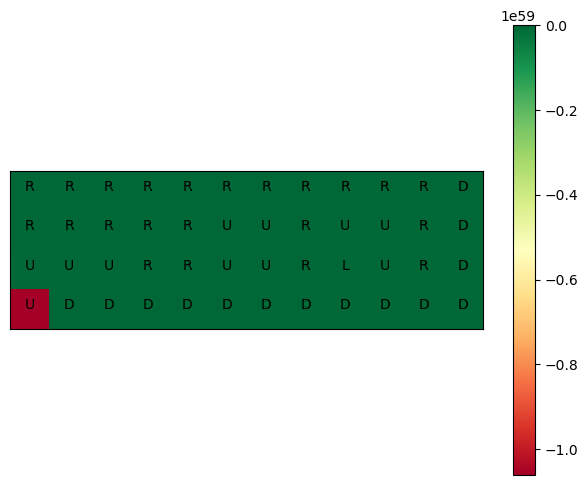


 Matriz de mejor acción-valor (en números): 

 [[-1.54960888e+54 -1.58166528e+53 -4.24472443e+49 -1.88216164e+49
  -1.63942910e+39 -4.42920833e+35 -1.03329264e+34 -2.75408047e+32
  -1.27194229e+27 -8.01359589e+22 -1.09680747e+21 -1.55025832e+19]
 [-6.41155594e+54 -1.30470380e+53 -1.03765840e+51 -5.54172013e+45
  -1.37150502e+44 -8.85620465e+38 -9.34989634e+30 -5.88083266e+31
  -1.62408819e+30 -2.28992735e+24 -7.29178271e+20 -5.02737473e+14]
 [-5.85837928e+56 -3.74017867e+53 -2.47237720e+52 -2.01042715e+45
  -9.82316002e+43 -1.54106425e+40 -1.22119010e+33 -3.50360614e+31
  -1.26701151e+31 -3.74997143e+25 -2.06782064e+14 -1.00000000e+00]
 [-1.06069171e+59 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
  -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+02
  -1.00000000e+02 -1.00000000e+02 -1.00000000e+02 -1.00000000e+00]]


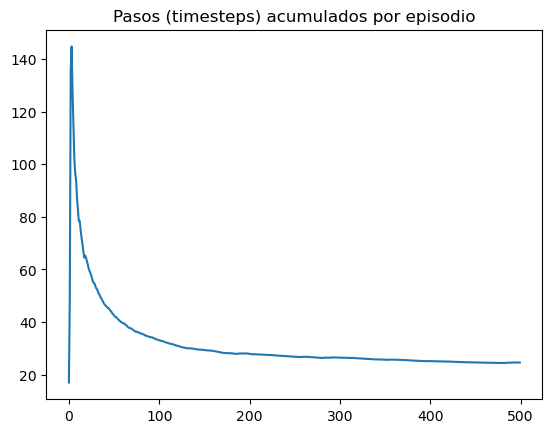

Ejecutando con los siguientes parámetros: alpha=0.1, gamma=100, epsilon=0.5


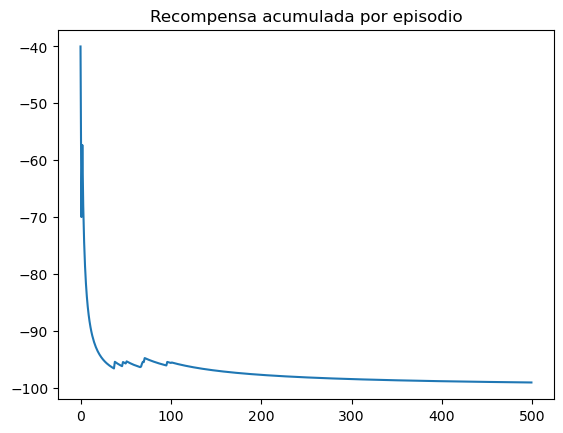

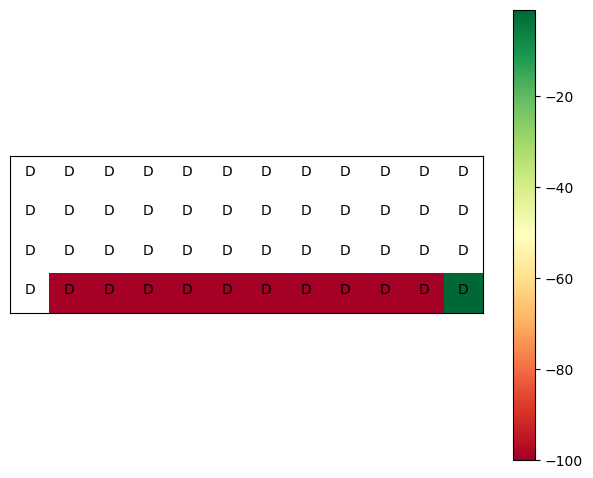


 Matriz de mejor acción-valor (en números): 

 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


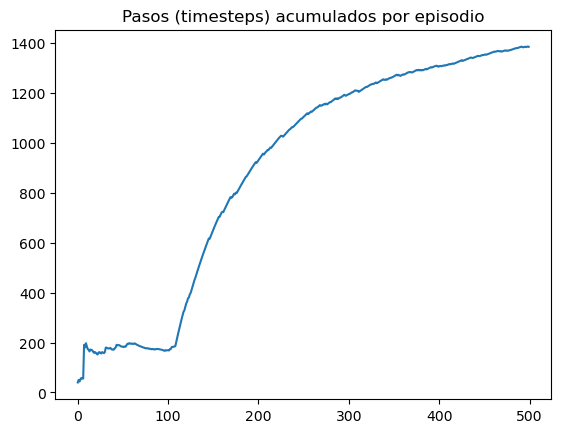

Ejecutando con los siguientes parámetros: alpha=0.1, gamma=100, epsilon=0.9


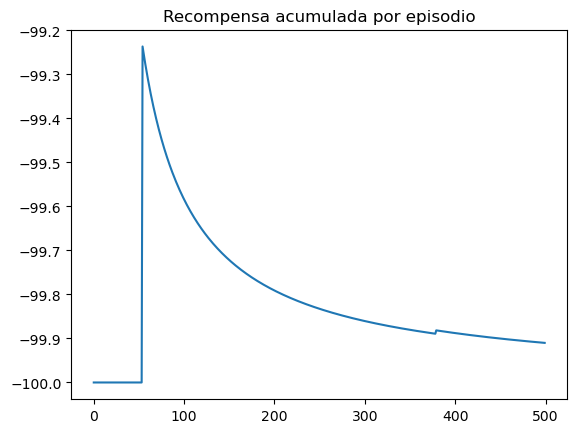

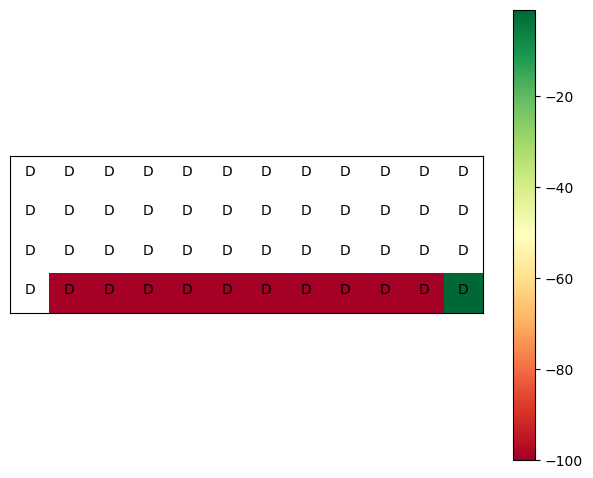


 Matriz de mejor acción-valor (en números): 

 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


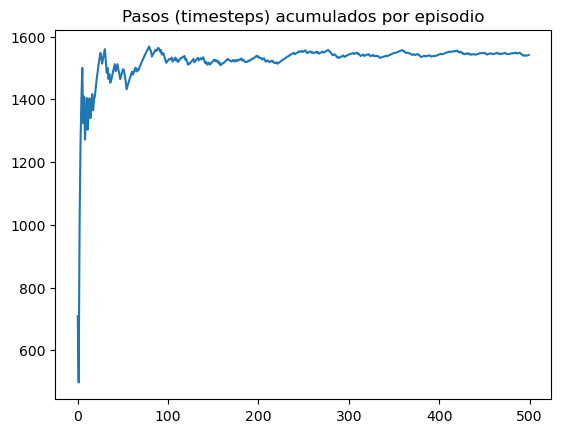

Ejecutando con los siguientes parámetros: alpha=0.1, gamma=1000, epsilon=0.1


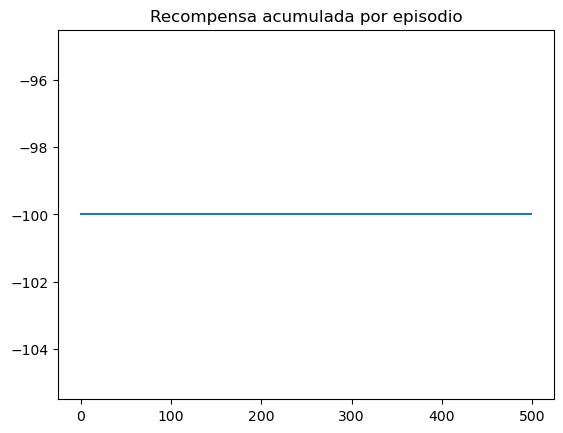

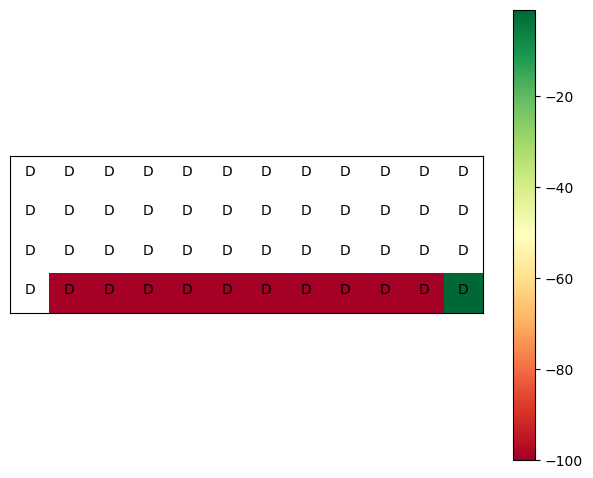


 Matriz de mejor acción-valor (en números): 

 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


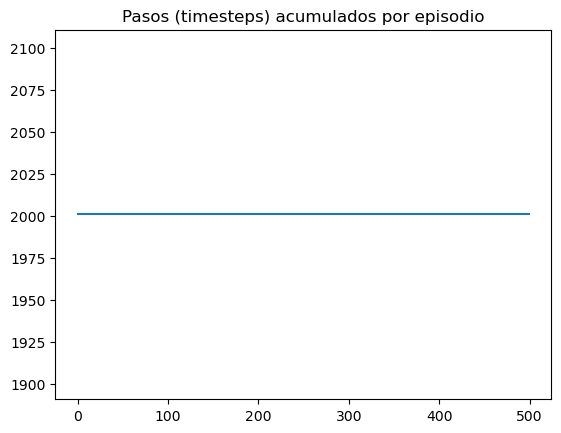

Ejecutando con los siguientes parámetros: alpha=0.1, gamma=1000, epsilon=0.5


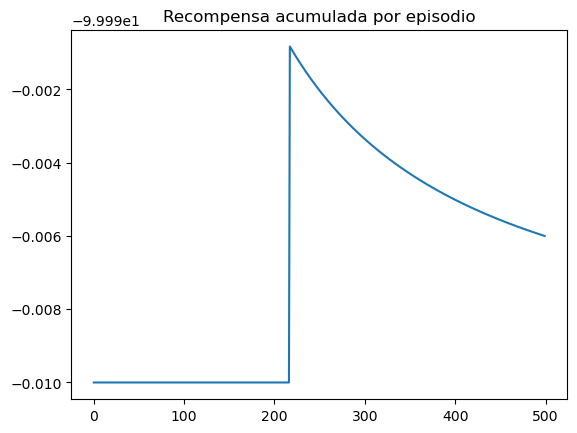

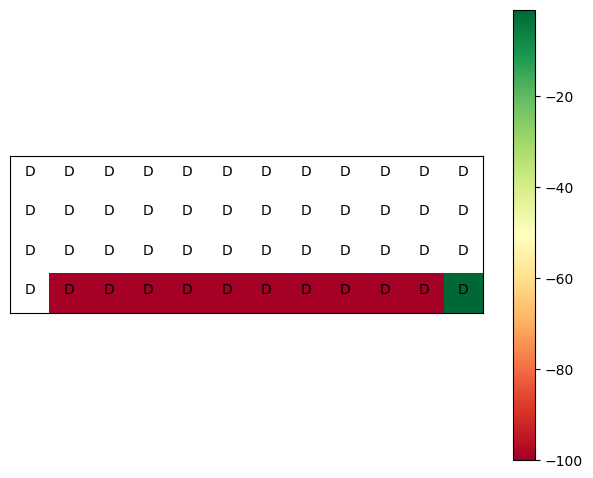


 Matriz de mejor acción-valor (en números): 

 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


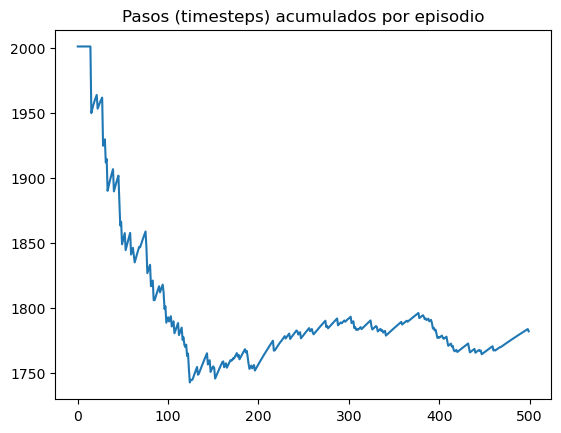

Ejecutando con los siguientes parámetros: alpha=0.1, gamma=1000, epsilon=0.9


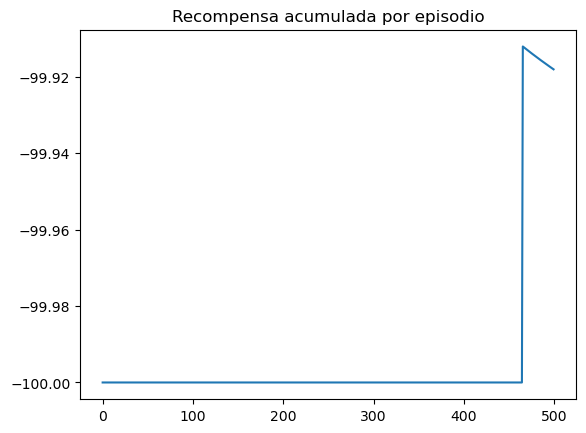

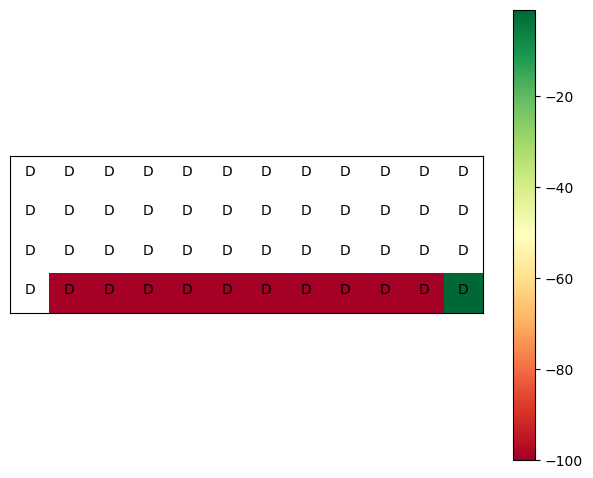


 Matriz de mejor acción-valor (en números): 

 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


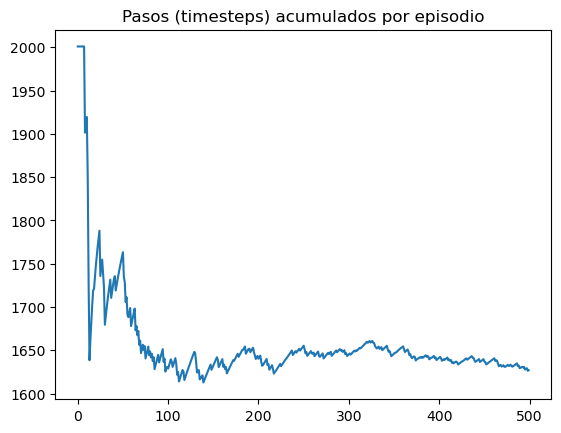

Ejecutando con los siguientes parámetros: alpha=0.3, gamma=1, epsilon=0.1


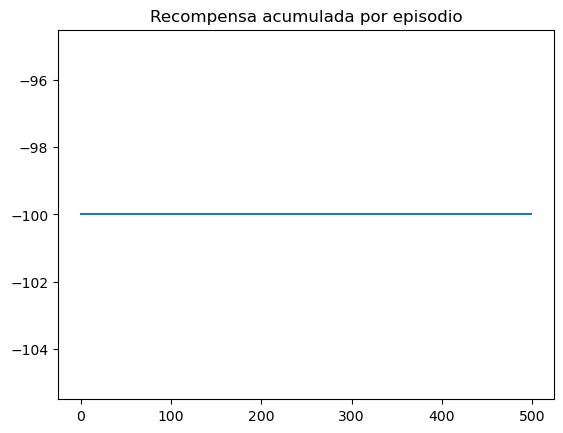

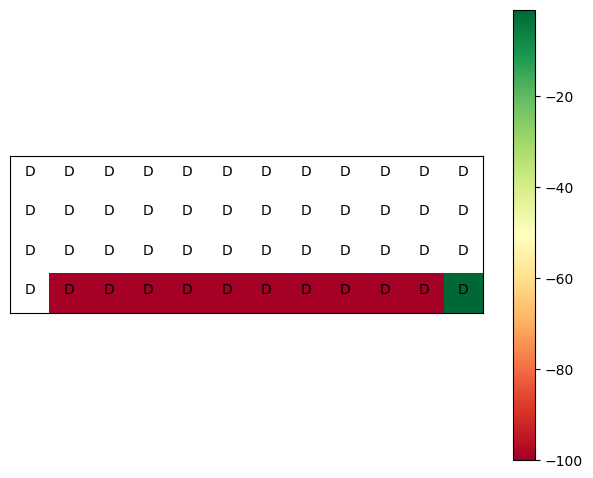


 Matriz de mejor acción-valor (en números): 

 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


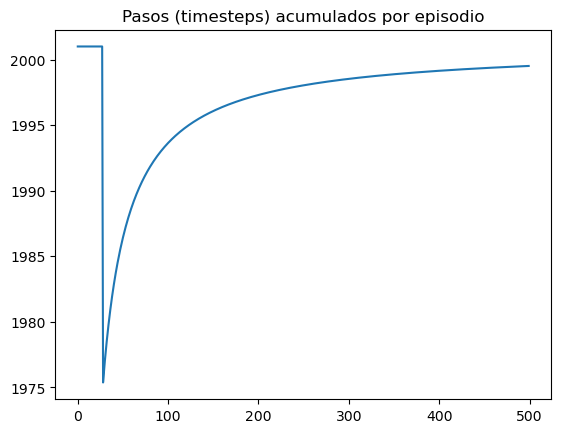

Ejecutando con los siguientes parámetros: alpha=0.3, gamma=1, epsilon=0.5


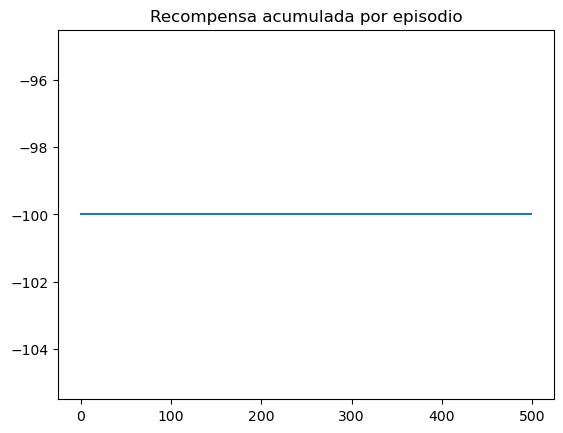

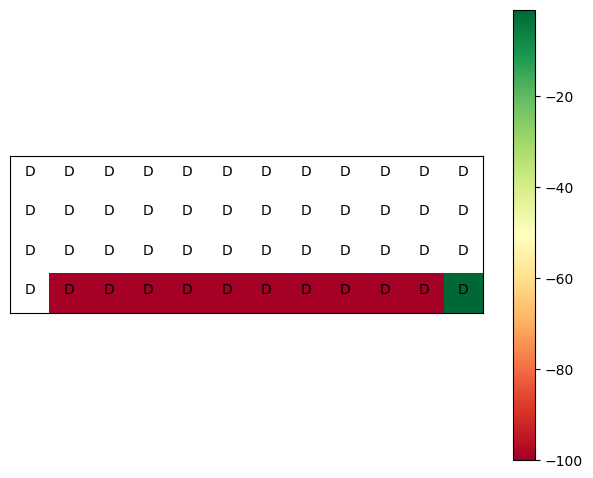


 Matriz de mejor acción-valor (en números): 

 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


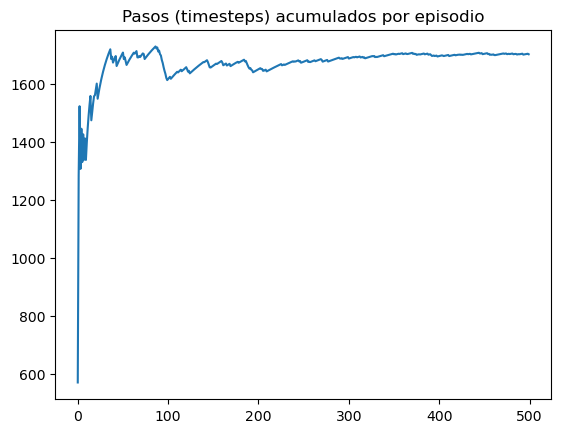

Ejecutando con los siguientes parámetros: alpha=0.3, gamma=1, epsilon=0.9


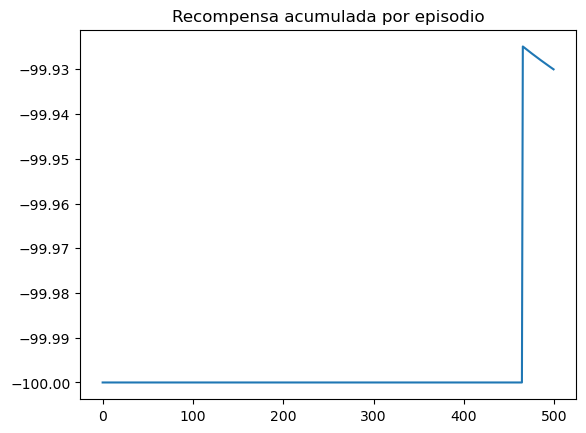

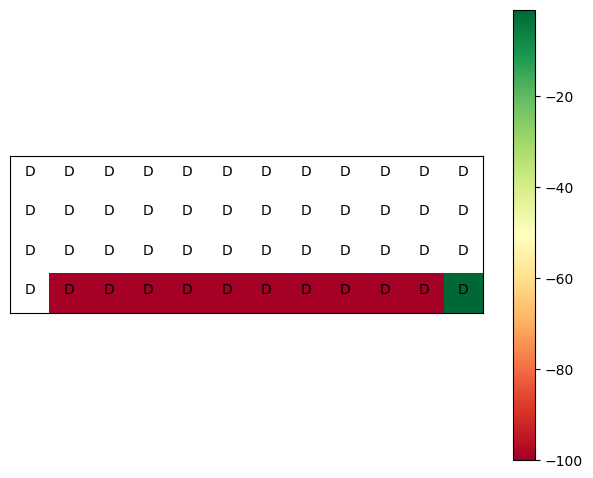


 Matriz de mejor acción-valor (en números): 

 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


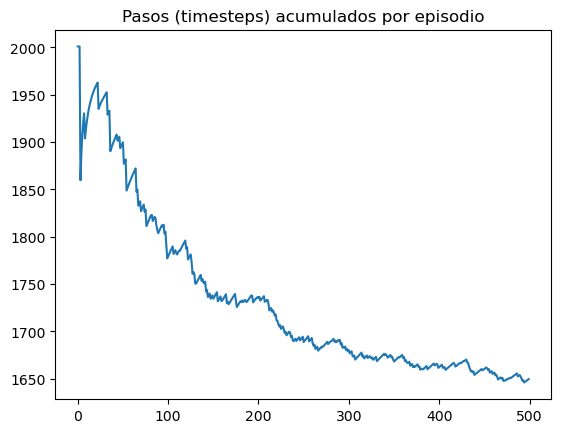

Ejecutando con los siguientes parámetros: alpha=0.3, gamma=100, epsilon=0.1


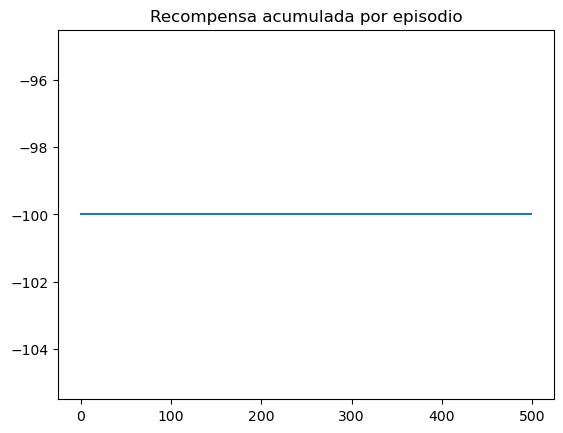

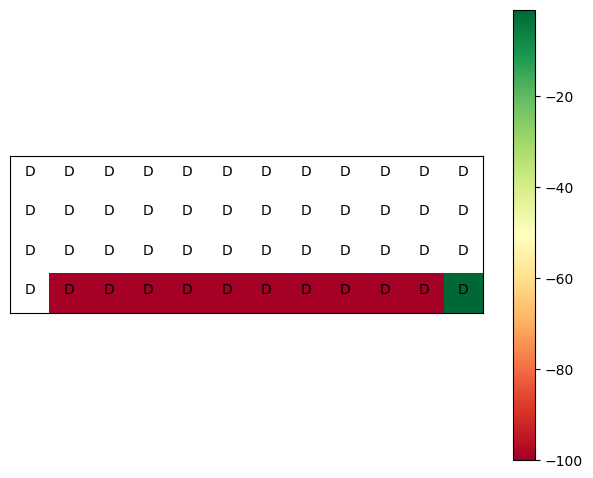


 Matriz de mejor acción-valor (en números): 

 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


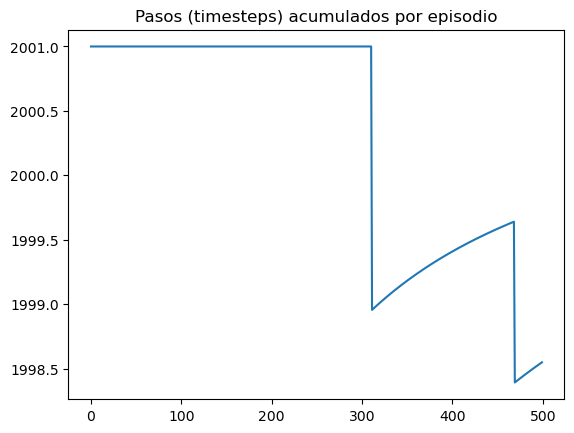

Ejecutando con los siguientes parámetros: alpha=0.3, gamma=100, epsilon=0.5


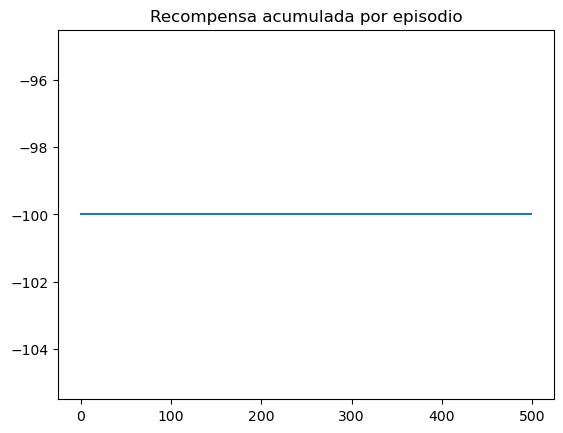

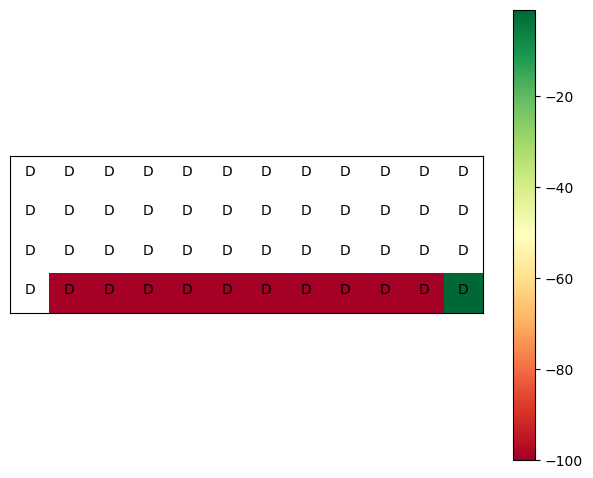


 Matriz de mejor acción-valor (en números): 

 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


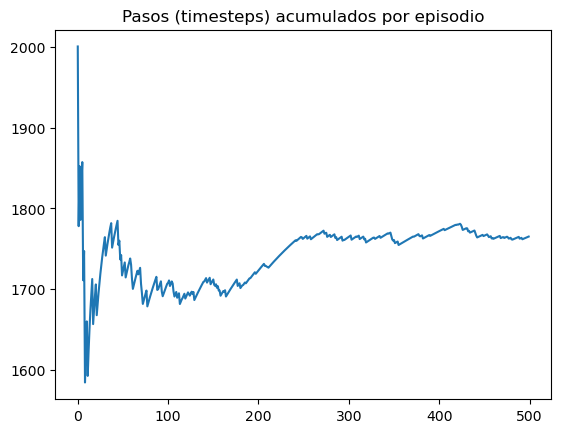

Ejecutando con los siguientes parámetros: alpha=0.3, gamma=100, epsilon=0.9


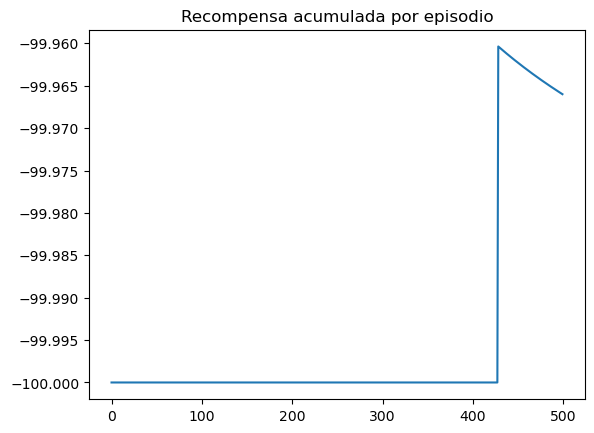

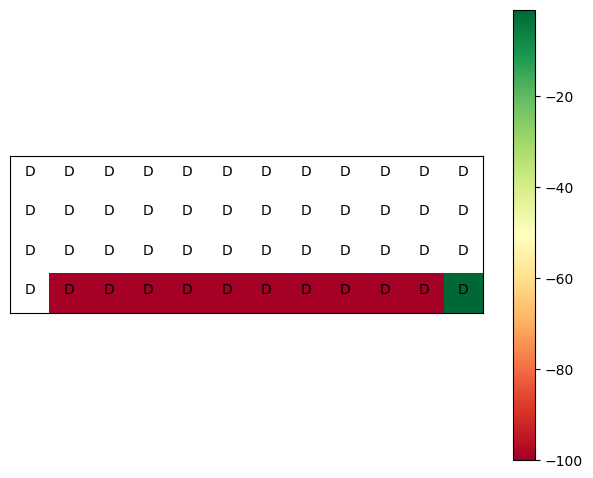


 Matriz de mejor acción-valor (en números): 

 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


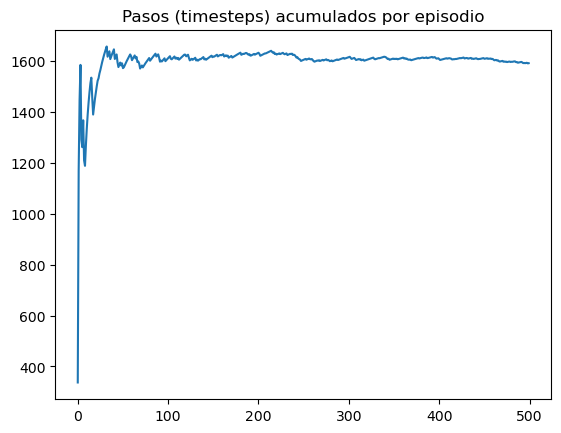

Ejecutando con los siguientes parámetros: alpha=0.3, gamma=1000, epsilon=0.1


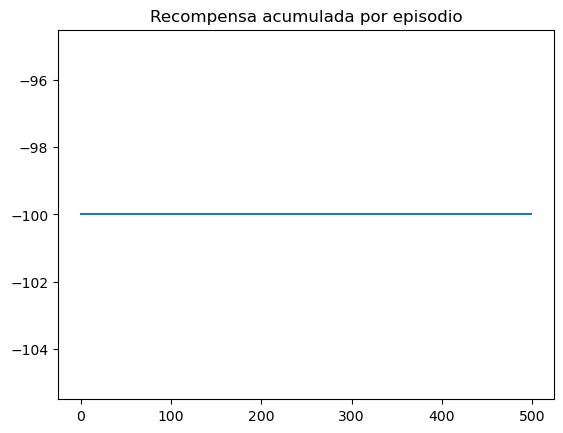

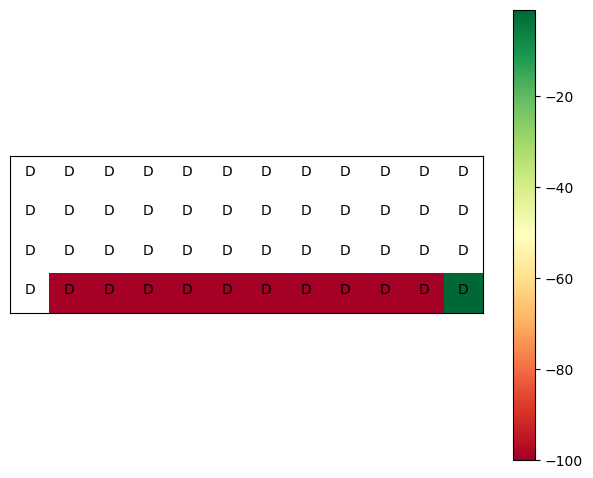


 Matriz de mejor acción-valor (en números): 

 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


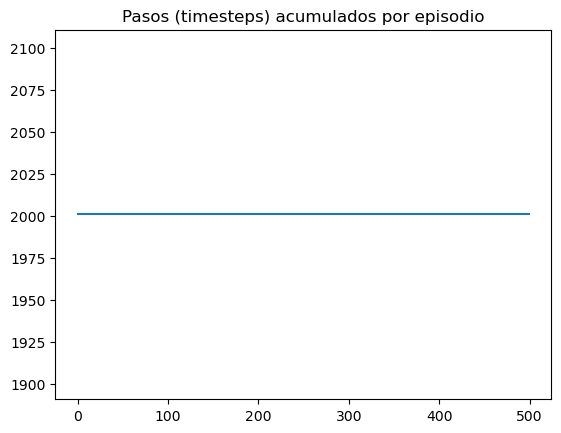

Ejecutando con los siguientes parámetros: alpha=0.3, gamma=1000, epsilon=0.5


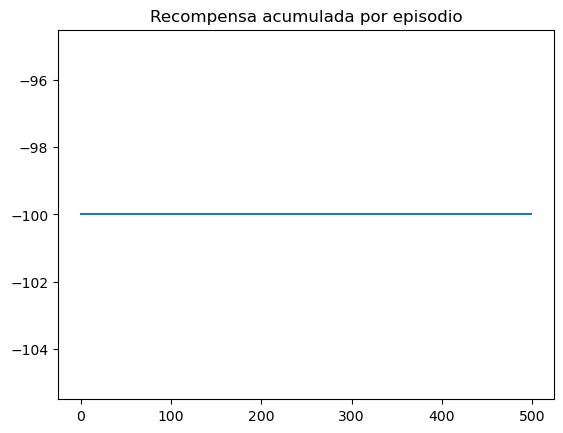

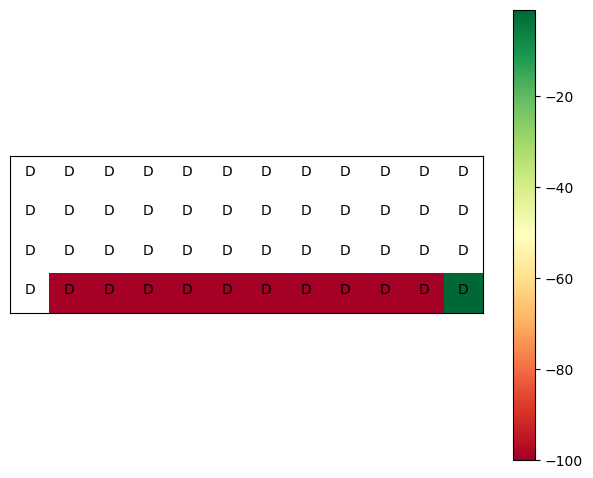


 Matriz de mejor acción-valor (en números): 

 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


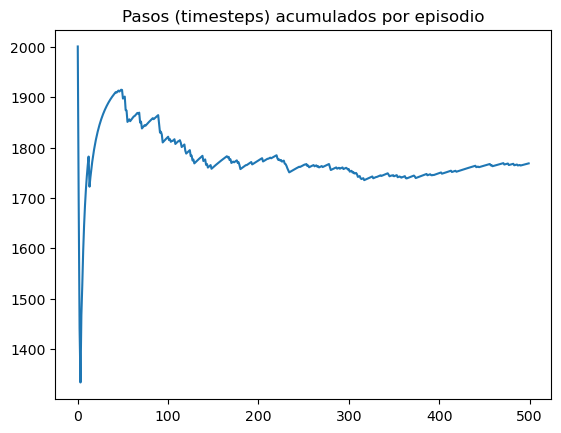

Ejecutando con los siguientes parámetros: alpha=0.3, gamma=1000, epsilon=0.9


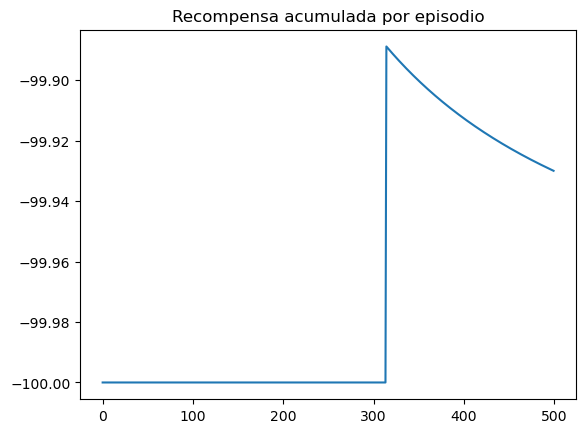

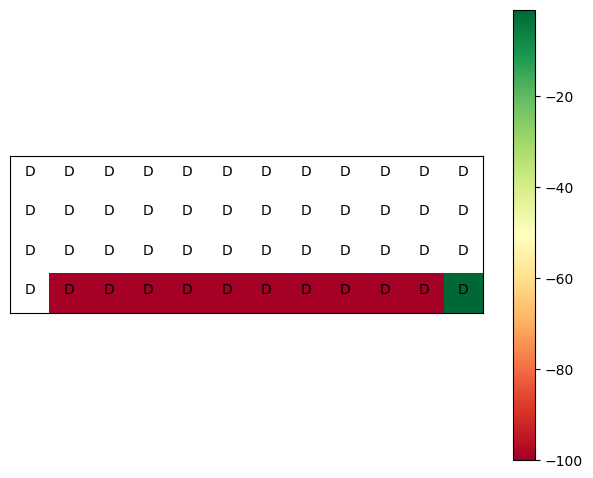


 Matriz de mejor acción-valor (en números): 

 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


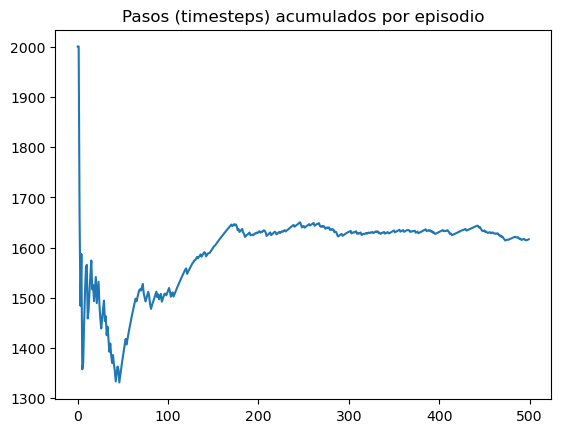

Ejecutando con los siguientes parámetros: alpha=0.4, gamma=1, epsilon=0.1


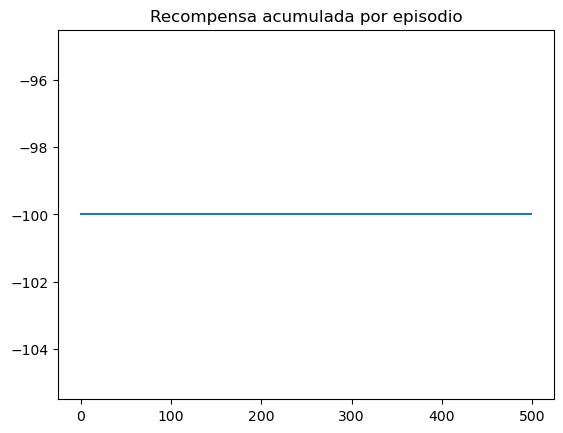

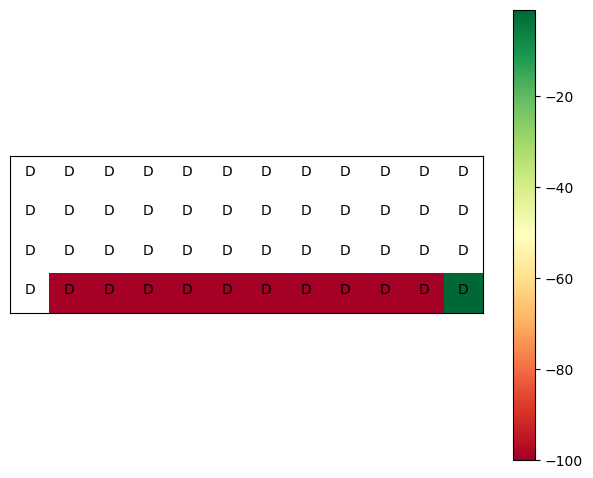


 Matriz de mejor acción-valor (en números): 

 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


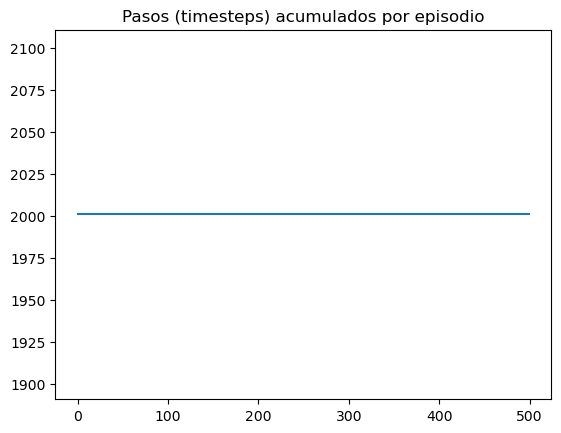

Ejecutando con los siguientes parámetros: alpha=0.4, gamma=1, epsilon=0.5


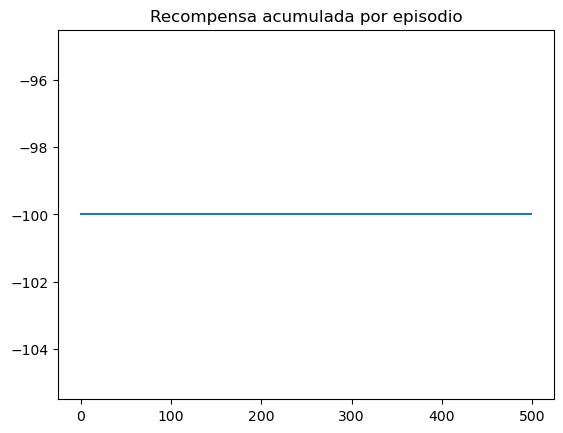

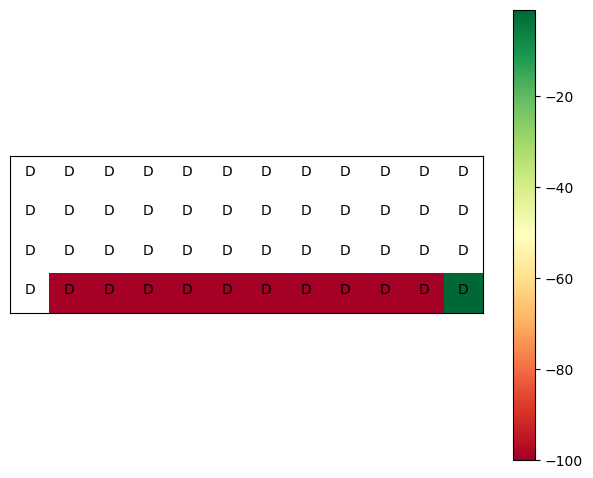


 Matriz de mejor acción-valor (en números): 

 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


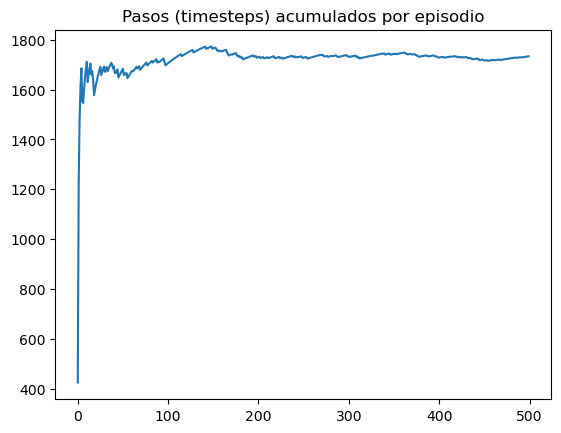

Ejecutando con los siguientes parámetros: alpha=0.4, gamma=1, epsilon=0.9


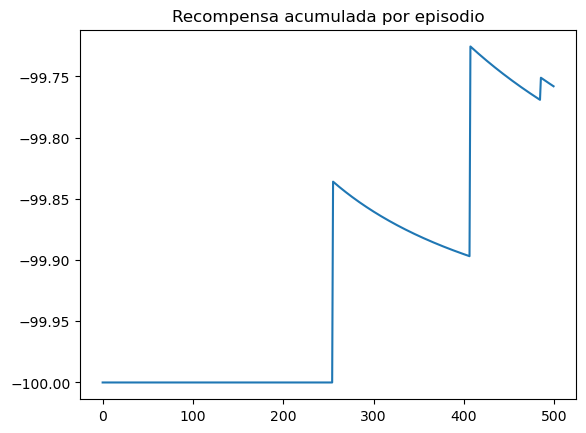

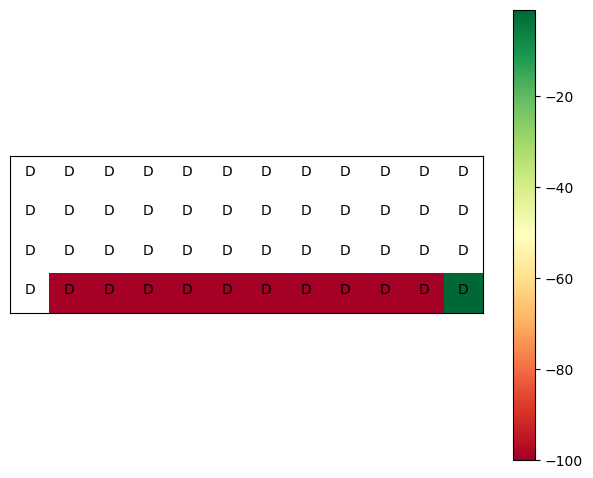


 Matriz de mejor acción-valor (en números): 

 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


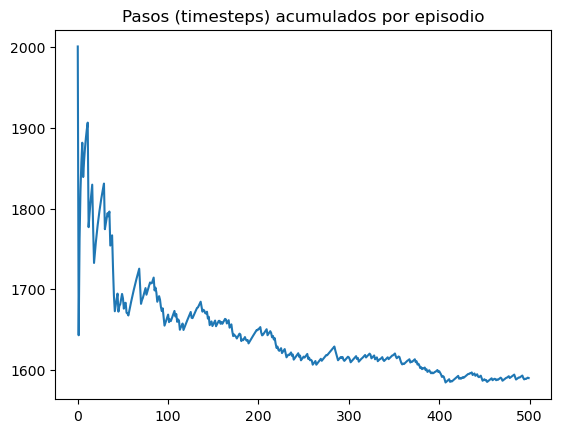

Ejecutando con los siguientes parámetros: alpha=0.4, gamma=100, epsilon=0.1


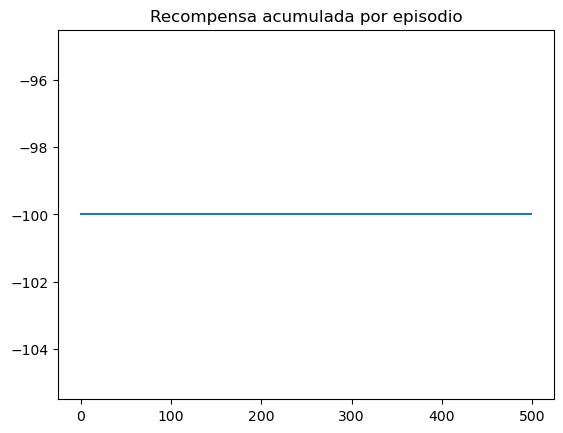

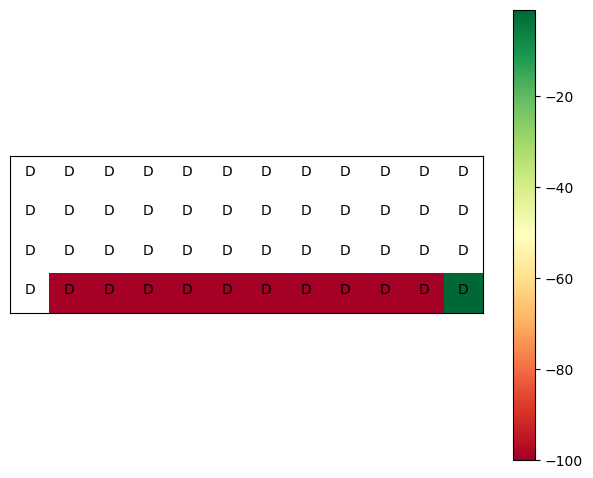


 Matriz de mejor acción-valor (en números): 

 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


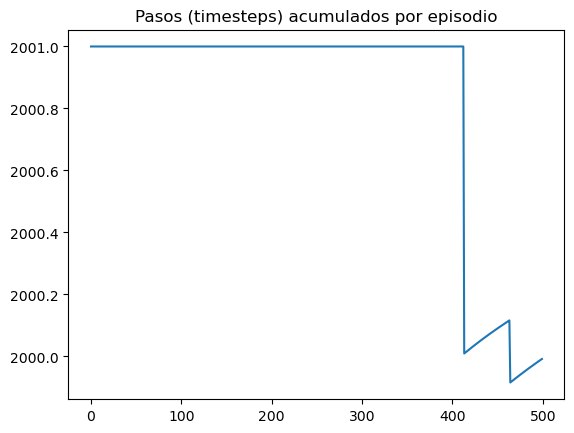

Ejecutando con los siguientes parámetros: alpha=0.4, gamma=100, epsilon=0.5


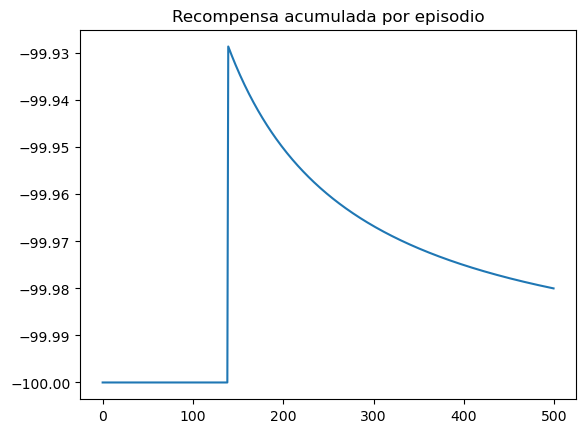

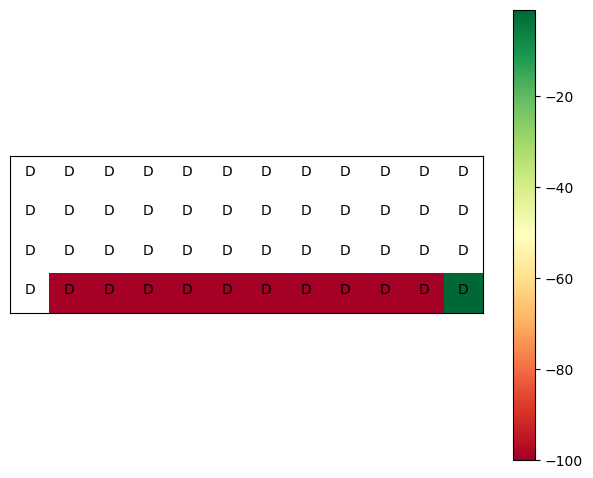


 Matriz de mejor acción-valor (en números): 

 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


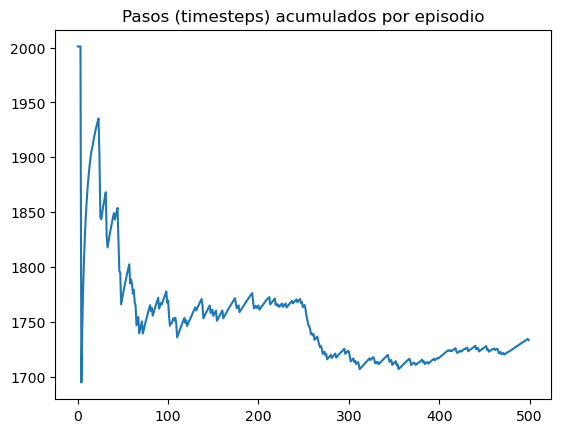

Ejecutando con los siguientes parámetros: alpha=0.4, gamma=100, epsilon=0.9


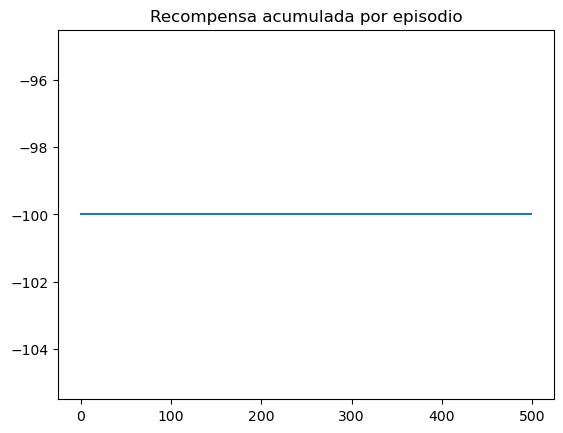

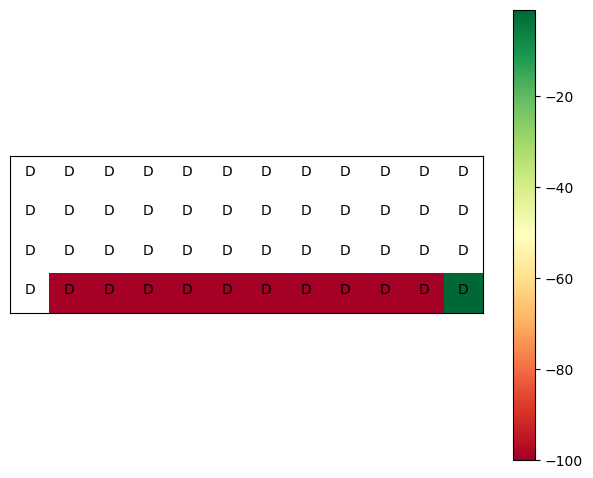


 Matriz de mejor acción-valor (en números): 

 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


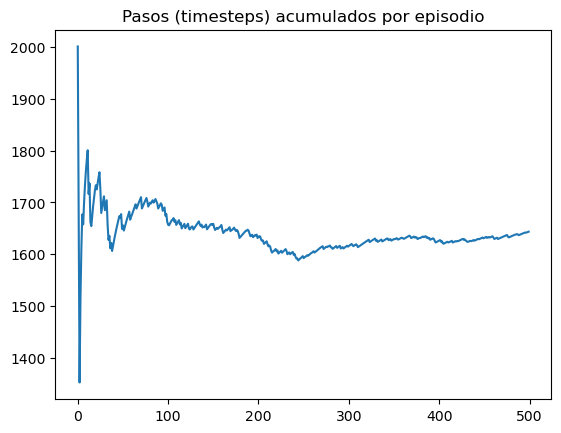

Ejecutando con los siguientes parámetros: alpha=0.4, gamma=1000, epsilon=0.1


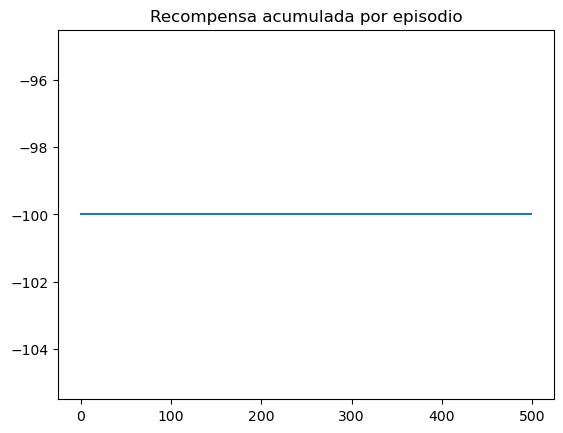

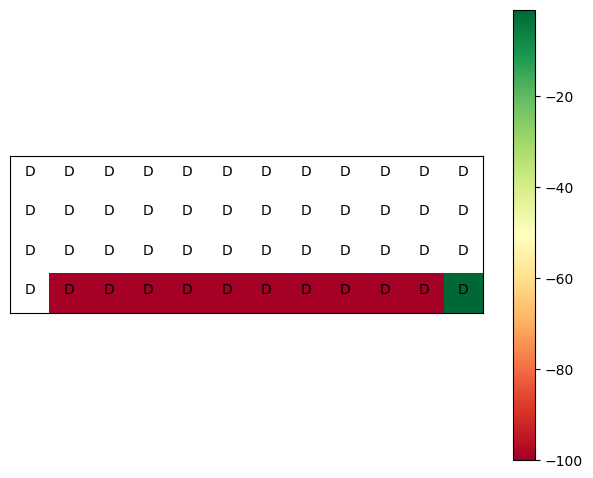


 Matriz de mejor acción-valor (en números): 

 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


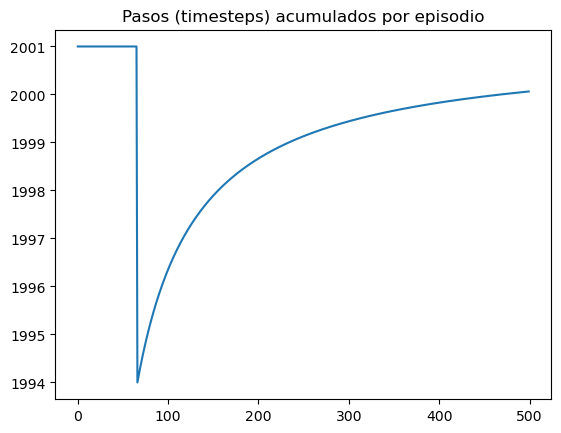

Ejecutando con los siguientes parámetros: alpha=0.4, gamma=1000, epsilon=0.5


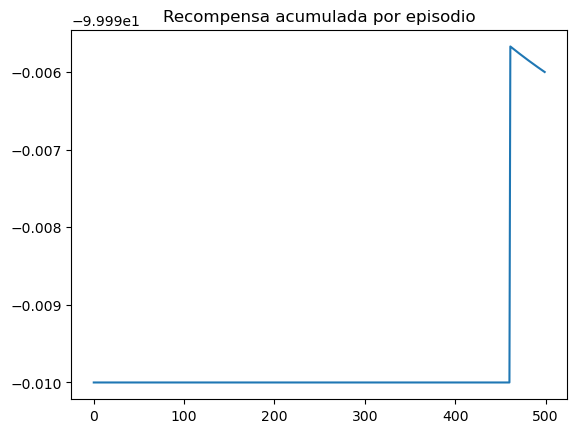

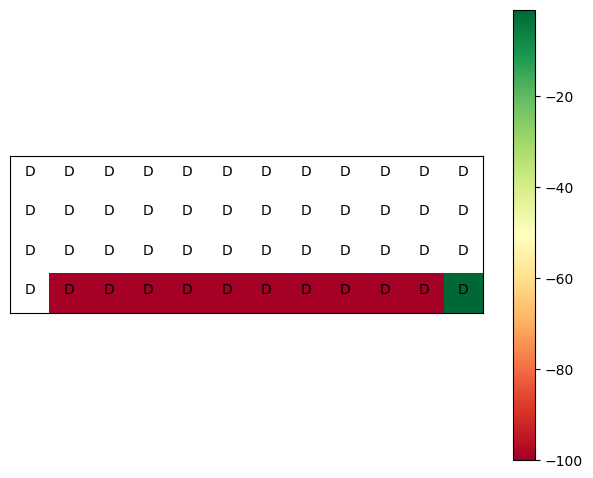


 Matriz de mejor acción-valor (en números): 

 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


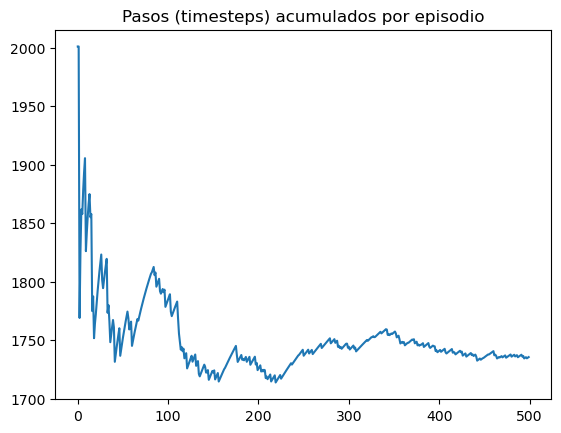

Ejecutando con los siguientes parámetros: alpha=0.4, gamma=1000, epsilon=0.9


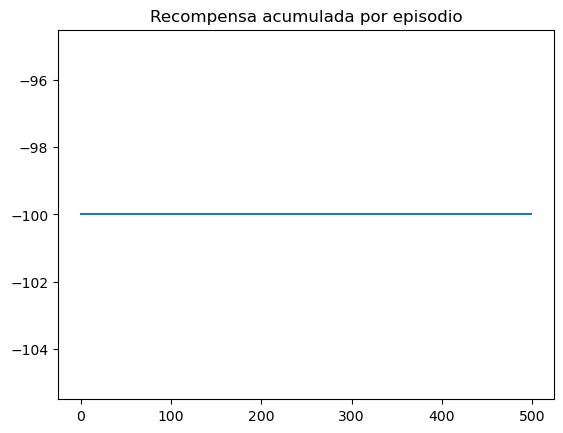

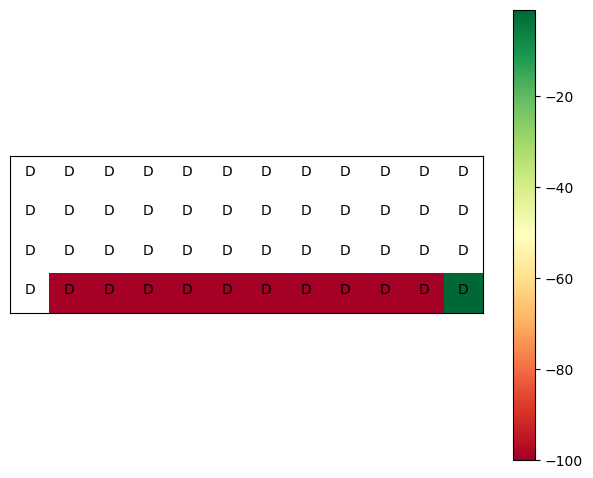


 Matriz de mejor acción-valor (en números): 

 [[  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


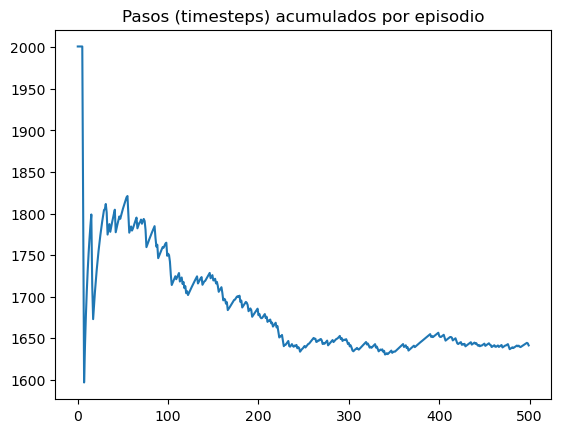

In [23]:
q = {}

hyperparameters_range = {
    "alpha": [0.1, 0.3, 0.4],
    "gamma": [1, 100, 1000],
    "epsilon": [0.1, 0.5, 0.9],
    "tau": 25,
}

learning_function = learn_SARSA
episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# Se declara una semilla aleatoria
random_state = np.random.RandomState(42)

# Genera todas las combinaciones de hiperparámetros
param_combinations = list(itertools.product(hyperparameters_range["alpha"], hyperparameters_range["gamma"], hyperparameters_range["epsilon"]))

for alpha, gamma, epsilon in param_combinations:
    hyperparameters = {
        "alpha": alpha,
        "gamma": gamma,
        "epsilon": epsilon,
        "tau": hyperparameters_range["tau"]
    }
    avg_steps_per_episode, timesteps_ep, reward_ep = run(
        learning_function,
        hyperparameters,
        episodes_to_run,
        env,
        actions,
        q,
        random_state
    )
    print(f"Ejecutando con los siguientes parámetros: alpha={alpha}, gamma={gamma}, epsilon={epsilon}")
    plot_reward_per_episode(reward_ep)
    draw_value_matrix(q)
    plot_steps_per_episode_smooth(timesteps_ep)

Ejecutando SARSA con diferentes valores de hiperparámetros en el entorno "The Cliff," hemos observado cómo estos afectan la convergencia del algoritmo. Hemos utilizado la siguiente lista de hiperparámetros:
    
    "alpha": [0.1, 0.3, 0.4]
    
    "gamma": [1, 100, 1000]
    
    "epsilon": [0.1, 0.5, 0.9]
    
    "tau": 25

**Tasa de Aprendizaje (α):**

* Con valores bajos de α (por ejemplo, 0.1), SARSA aprende lentamente y converge de manera mas "firme".
* Valores altos de α (por ejemplo, 0.4) aceleran el proceso de aprendizaje, lo que conduce a una convergencia más rápida.

**Factor de Descuento (γ):**

* Un valor bajo de γ (por ejemplo, 1) da prioridad a las recompensas inmediatas, lo que conduce a una convergencia más rápida hacia una política de recompensa inmediata. Esto puede resultar en una política de corto plazo que no es óptima a largo plazo.
* Valores más altos de γ (por ejemplo, 100 o 1000) favorecen las recompensas a largo plazo y hacen que haya una planificación a largo plazo. Aunque la convergencia es más lenta, como en el caso de alpha, esto puede resultar en una política más firme a largo plazo.

**Tasa de Exploración (ε):**

* Con un valor bajo de ε (por ejemplo, 0.1), SARSA se vuelve más explotativo y tiende a elegir principalmente acciones que ya ha aprendido como las mejores. Esto acelera la convergencia pero puede llevar al agente a quedar atrapado en una política subóptima si no explora lo suficiente, como vemos en el grafico de los valores alpha=0.1, gamma=1, epsilon=0.9.
* Valores más altos de ε (por ejemplo, 0.9) hacen que SARSA sea más exploratorio, lo que ralentiza la convergencia, pero permite al agente descubrir políticas óptimas a largo plazo.

Luego de comenzar a subir todos los hiperparametros a las ultimas iteraciones, podemos ver que se le hace mas dificil conseguir llegar a la meta en cada uno de los casos.

## Actividades

1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".

2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

4. (Opcional) Implementar política de exploración Softmax, en donde cada acción tiene una probabilidad $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

5. (Opcional) Implementar Dyna-Q a partir del algoritmo Q-Learning, incorporando una actualización mediante un modelo. Comentar cómo se desempeña respecto a los demás algoritmos.


Para dejar el lab listo para su corrección, dejar link a repo de Github con un notebook ejecutando el agente en la planilla enviada en Slack.

FIN